# Analysis of Variance of Read Counts
To support evaluation of classifiers, we need to know the variance (standard deviations) of read counts that are normalized in several ways: by library size, by gene size, and w.r.t. time 0. Two variances are of interest. The first is the variability of replications for the same gene and time. The second is the variability of mean values of replicas for a gene.

In [1]:
import init
from common import constants as cn
from common.data_provider import DataProvider
from common_python.util import dataframe
from common_python.plots import util_plots
from common_python.plots.plotter import Plotter
from common_python.classifier.random_hypergrid_harness import RandomHypergridHarness

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.distributions.empirical_distribution as stats

%matplotlib inline

## Data

In [2]:
provider = DataProvider()
provider.do()

In [3]:
# The data used in this analysis is a list of dataframe "matrix" that are the log2 values of the
# libary and gene adjusted readcounts divided by time 0.
# Each data frame has columns of genes and rows of time.
dfs_raw = provider.dfs_adjusted_read_count_wrt0
# Ignore the first timepoint since it's one because it's the reference.
dfs_nonref = [df.T[1:] for df in dfs_raw]
# Eliminate nan values
dfs_data = []
for df in dfs_nonref:
    dfs_data.append(df.applymap(lambda v: 0 if v == 0 else np.log(v)))

In [4]:
dfs_data[0].head()

,Rv0001,Rv0005,Rv0006,Rv0009,Rv0010c,Rv0011c,Rv0013,Rv0014c,Rv0016c,Rv0020c,...,Rvnt36,Rvnt37,Rvnt38,Rvnt39,Rvnt40,Rvnt41,Rvnt42,Rvnt43,Rvnt44,Rvnt45
1,0.069637,0.493369,0.487471,0.672798,0.321152,-0.003061,0.510698,0.493491,0.318525,0.388921,...,-0.700615,-0.232011,-0.850888,-0.786681,-0.164679,0.370297,-0.826179,-0.293972,-0.422338,-0.153859
2,0.263746,0.548655,0.418436,0.871489,0.148821,0.142356,0.404373,0.486426,0.340078,0.506673,...,-0.026669,-0.761059,-0.897696,-0.575918,-0.337511,0.807163,-0.660811,-0.336057,-0.007541,-0.372408
3,0.227287,0.713353,0.660986,0.566662,0.158351,0.430510,0.336514,0.399219,0.258814,0.437266,...,-1.087638,-0.994852,-0.601763,-1.113545,-0.105745,-0.005183,-0.635061,-2.133763,0.129770,-1.260719
4,0.302584,0.685229,0.656924,0.715749,0.127734,0.182507,0.149349,0.496310,0.340376,0.446260,...,-0.606678,-0.965603,-1.498965,-1.131399,-0.534326,0.208669,-1.744030,-2.899132,-0.789347,-2.112273
5,0.242560,0.687753,0.457919,0.697571,0.236662,0.345702,0.383418,0.521504,0.248118,0.619110,...,-0.893606,-1.596221,-1.938030,-1.346561,-0.335814,0.332139,-1.984260,-1.365403,-0.556671,-1.787842


In [5]:
dfs_data[1].head()

,Rv0001,Rv0005,Rv0006,Rv0009,Rv0010c,Rv0011c,Rv0013,Rv0014c,Rv0016c,Rv0020c,...,Rvnt36,Rvnt37,Rvnt38,Rvnt39,Rvnt40,Rvnt41,Rvnt42,Rvnt43,Rvnt44,Rvnt45
1,0.026580,0.138055,0.210720,0.529461,0.329360,0.102481,0.435406,0.154138,0.249899,0.258090,...,0.534493,0.975626,1.893861,0.786852,-0.010767,-0.624610,0.855833,0.297079,0.285376,1.567964
2,0.324912,0.475974,0.347902,0.789531,0.403294,0.342468,0.378178,0.349270,0.257155,0.379764,...,0.049911,0.487354,1.064901,0.010797,0.124629,-0.367596,-0.278820,-0.945771,0.062134,0.390440
3,0.150678,0.305756,0.504589,0.427874,0.240316,0.125952,0.359089,0.228570,0.295715,0.348850,...,0.363724,1.003249,1.322216,-0.728707,-0.692735,-0.062877,0.537431,-1.402739,0.368108,0.650801
4,0.052264,0.309769,0.444228,0.511833,0.099089,0.058976,0.242198,0.238278,0.323161,0.479204,...,-0.296242,0.778796,1.065065,-0.203776,-0.264700,0.226757,0.250092,-1.022031,0.216741,0.081810
5,0.130206,0.289055,0.119414,0.178876,0.014348,0.008050,-0.048069,0.034901,0.139673,0.168447,...,0.768930,1.367824,1.833502,0.956521,0.318199,-0.131725,0.871278,1.082750,0.145633,0.893727


In [6]:
dfs_data[2].head()

,Rv0001,Rv0005,Rv0006,Rv0009,Rv0010c,Rv0011c,Rv0013,Rv0014c,Rv0016c,Rv0020c,...,Rvnt36,Rvnt37,Rvnt38,Rvnt39,Rvnt40,Rvnt41,Rvnt42,Rvnt43,Rvnt44,Rvnt45
1,-0.049259,0.233470,0.168745,0.393708,0.093980,-0.075847,0.159526,0.003408,0.218691,0.150945,...,0.301680,0.241831,0.662514,0.012031,-0.169626,-0.680566,0.110902,0.101967,0.271476,0.781683
2,0.239653,0.488996,0.392984,0.541217,0.089068,0.211198,0.044357,0.037833,0.289569,0.344453,...,0.211673,0.122141,0.812823,0.172285,-0.429341,0.293526,0.241376,-0.328894,0.406029,-0.015805
3,0.153105,0.373702,0.529114,0.470078,0.068674,0.252405,0.000815,0.188571,0.302770,0.328342,...,-0.374234,0.322524,0.247267,-0.375072,-0.056829,0.220876,-0.245604,-0.541947,0.308686,-1.192570
4,0.057715,0.443450,0.495075,0.486260,0.182562,0.025538,0.167300,0.268949,0.361929,0.470058,...,-0.514744,-0.156459,0.640790,-0.260005,-0.601014,0.027937,-0.178358,-0.745230,0.158610,-0.050914
5,0.003791,0.403282,0.435062,0.335115,-0.000697,0.001247,-0.107879,-0.017771,0.187169,0.439808,...,-0.157188,0.218300,0.571036,-0.395428,-0.318903,0.387199,-0.138256,-0.755490,0.433771,-0.499965


In [7]:
len(dfs_data[0].columns)

2582

## Standard Deviation Between Timepoints By Gene

In [8]:
df_mean = sum(dfs_data)/len(dfs_data)
df_mean.head()
ser_stdb = df_mean.std() # Standard deviation between timepoints
ser_stdb.head()

Rv0001     0.271613
Rv0005     0.503033
Rv0006     0.504533
Rv0009     0.652856
Rv0010c    0.295875
dtype: float64

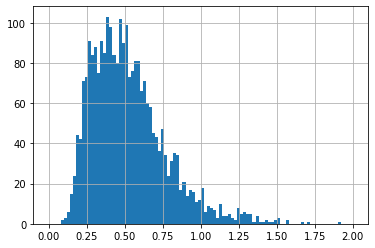

In [9]:
ax = ser_stdb.hist(bins=100, range=(0, 2), density=False)


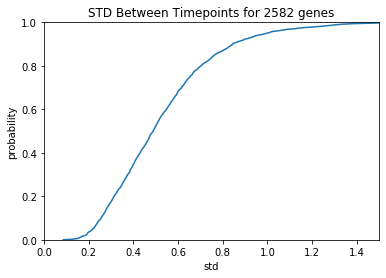

In [17]:
plotter = Plotter()
ecdf = stats.ECDF(ser_stdb)
plotter.ax.plot(ecdf.x, ecdf.y)
plotter.do(xlim=[0, 1.5], ylim=[0, 1.0], 
           title="STD Between Timepoints for %d genes" % len(df_mean.columns), 
           xlabel="std", ylabel="probability")

## Standard Deviation Within Gene, Timepoint
This is the standard deviation across replications for a gene and timepoint. We use the average value across timepoints for each gene.

In [11]:
df_stdw = dataframe.std(dfs_data)  # Dataframe of standard deviations within a timepoint
ser_stdw = df_stdw.mean()
#ser_stdw = pd.Series(np.reshape(df_stdw.to_numpy(), df_stdw.size))  # Convert to a series
ser_stdw.head()

Rv0001     0.023080
Rv0005     0.048038
Rv0006     0.039000
Rv0009     0.068523
Rv0010c    0.013107
dtype: float64

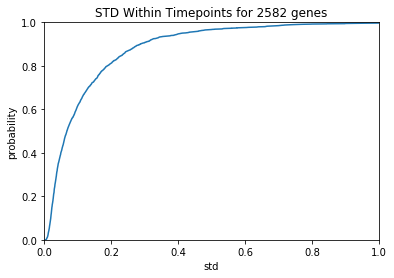

In [19]:
plotter = Plotter()
ecdf = stats.ECDF(ser_stdw)
plotter.ax.plot(ecdf.x, ecdf.y)
plotter.do(xlim=[0, 1], ylim=[0, 1.0], title="STD Within Timepoints for %d genes" % len(df_stdw.columns), 
           xlabel="std", ylabel="probability")

## Analysis of Top Genes
These are genes identified by SVM classifier as having the most effect on the classification vector as indicated by the plot below.
![](pngs/top10genes.png)
![](pngs/top15genes.png)

In [14]:
STDB = "stdb"
STDW = "stdw"
top_genes10 = ["Rv2382c", "Rv2329c", "Rv3083", "Rv2958c", "Rv3613c", "Rv2385", "Rv3841", "Rv3342", "Rv0040c"]
top_genes15 = ["Rv0886", "Rv2382c", "Rv3083", "Rv3613c", "Rv2329c", "Rv3136", "Rv2958c", "Rv3841", "Rv2377c",
            "Rv2380c", "Rv3342", "Rv1479", "Rv1700", "Rv2385"]
gene_dct = {k: {STDB: None, STDW: None} for k in top_genes15}
for gene in top_genes15:
    dct = gene_dct[gene]
    dct[STDB] = ser_stdb[gene]
    dct[STDW] = ser_stdw[gene]
df = pd.DataFrame(gene_dct)
df.transpose()

,stdb,stdw
Rv0886,0.934001,0.160486
Rv2382c,0.885436,0.177066
Rv3083,0.567923,0.048767
Rv3613c,0.516543,0.057823
Rv2329c,0.371466,0.042051
Rv3136,0.619226,0.072184
Rv2958c,0.734832,0.077032
Rv3841,0.811551,0.112700
Rv2377c,0.636836,0.036655
Rv2380c,0.650990,0.073587


In [15]:
dff = df.transpose()
dff[STDB] / dff[STDW]

Rv0886      5.819843
Rv2382c     5.000607
Rv3083     11.645625
Rv3613c     8.933242
Rv2329c     8.833641
Rv3136      8.578438
Rv2958c     9.539279
Rv3841      7.200991
Rv2377c    17.373939
Rv2380c     8.846522
Rv3342      8.774721
Rv1479      9.786620
Rv1700     15.006844
Rv2385      9.758903
dtype: float64

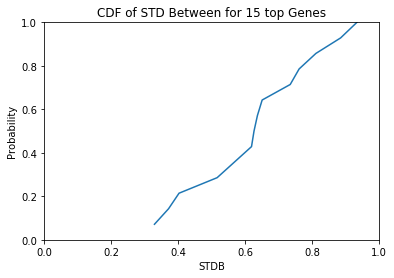

In [26]:
ecdf = stats.ECDF(dff[STDB])
plotter = Plotter()
plotter.ax.plot(ecdf.x, ecdf.y)
plotter.do(xlim=[0, 1], ylim=[0, 1.0], title="CDF of STD Between for 15 top Genes",
          xlabel="STDB", ylabel="Probability")

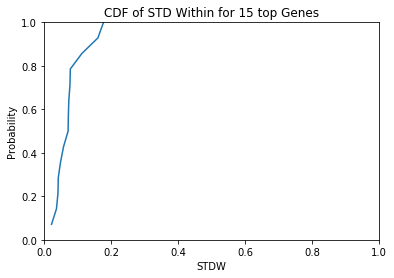

In [29]:
ecdf = stats.ECDF(dff[STDW])
plotter = Plotter()
plotter.ax.plot(ecdf.x, ecdf.y)
plotter.do(xlim=[0, 1], ylim=[0, 1.0], title="CDF of STD Within for 15 top Genes",
          xlabel="STDW", ylabel="Probability")

In [16]:
len(set(top_genes10).intersection(top_genes15))

8

Notes
1. Determine an more appropriate range for the accuracy studies based on top genes.